In [1]:
import pandas as pd
from pathlib import Path

import numpy as np
import xarray as xr
from matplotlib import pyplot as plt

from opera_tropo import checks
from opera_tropo.core import calculate_ztd


In [2]:
%%time
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/data/ECMWF_TROP_201606230600_201606230600_1.nc', chunks={})
vars_out = checks.check_nans_valid_range(ds)

   Variable "q" is out of valid range (0.0, 0.3): min = -0.00001 [<0.0],max = 1.69043 [>0.3]
   Variable "t" is out of valid range (140.0, 360.0): min = 82.57539 [<140.0],max = 606.28271 [>360.0]


CPU times: user 1min 11s, sys: 38 s, total: 1min 49s
Wall time: 1min 26s


In [3]:
anomaly_limits_index = np.where(ds.t.isel(time=0) > 360)[0:]

In [4]:
print('Anomaly  levels:', np.unique(anomaly_limits_index[0]))
lat_min, lat_max = np.min(anomaly_limits_index[1]), np.max(anomaly_limits_index[1])
print(f'Latitude, min: {ds.latitude[lat_min].values:.3f}, max {ds.latitude[lat_max].values:.3f}')
lon_min, lon_max = np.min(anomaly_limits_index[2]), np.max(anomaly_limits_index[2])
print(f'Latitude, min: {ds.longitude[lon_min].values:.3f}, max {ds.longitude[lon_max].values:.3f}')

Anomaly  levels: [123 126]
Latitude, min: 36.661, max 35.817
Latitude, min: 74.039, max 75.164


In [5]:
lat_slice =slice(lat_min-10, lat_max+10)
lon_slice =slice(lon_min-10, lon_max+10)

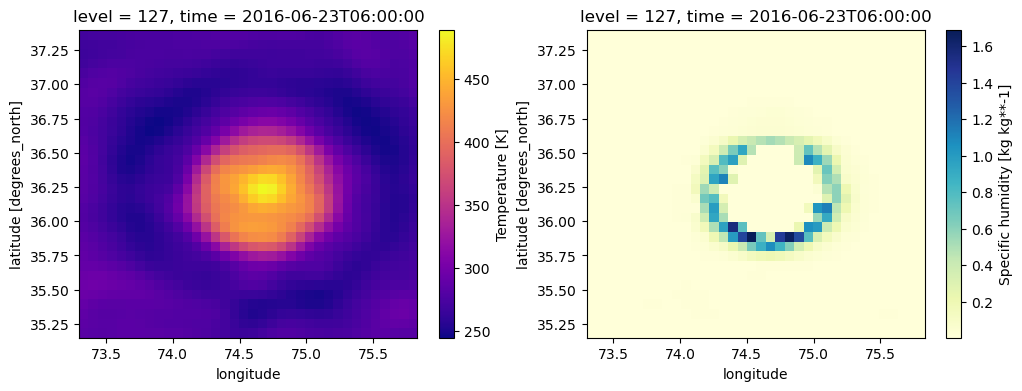

In [27]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,4))
ds.t.isel(time=0, level=126).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=ax[0], cmap='plasma')
ds.q.isel(time=0, level=126).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=ax[1], cmap='YlGnBu')

In [7]:
np.int16(np.rint(np.mean([lon_max, lon_min])))

1061

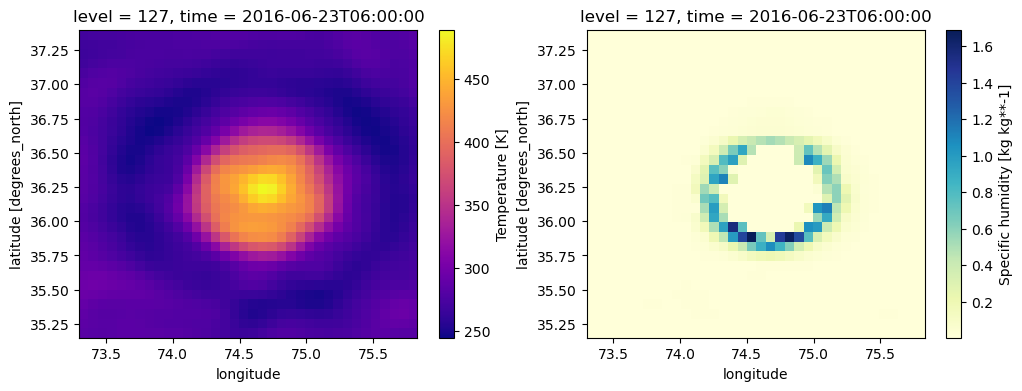

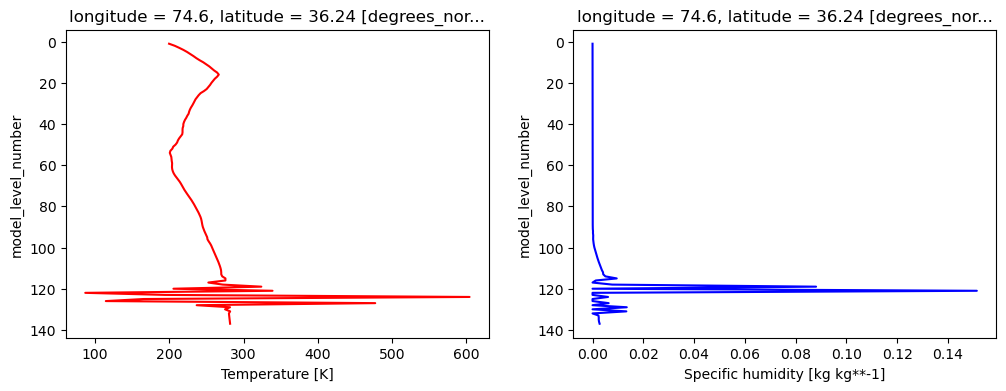

In [8]:
%matplotlib inline
fig, ax = plt.subplots(1,2, figsize=(12,4))
center_ds = ds.isel(time=0).isel(longitude=int(np.rint(np.mean([lon_max, lon_min]))),
                       latitude=int(np.rint(np.mean([lat_max, lat_min]))))

center_ds.t.plot(ax=ax[0], color='red', y='level')
center_ds.q.plot(ax=ax[1], color='blue', y='level')
for a in ax: a.invert_yaxis()

In [9]:
# Get heights 
from RAiDER.models import HRES

hres_model = HRES()
#Assign temperature and specific humidity
hres_model._t = center_ds.t.values
hres_model._q = center_ds.q.values

# Compute pressure and geopotential height from geopotential and log pressure
hres_model._p, hgt = hres_model._calculategeoh(center_ds.z.isel(level=0).values, 
                                               center_ds.lnsp.isel(level=0).values)[1:]

[-20   0  20  40  60  80 100 120 140 160]
[-20   0  20  40  60  80 100 120 140 160]


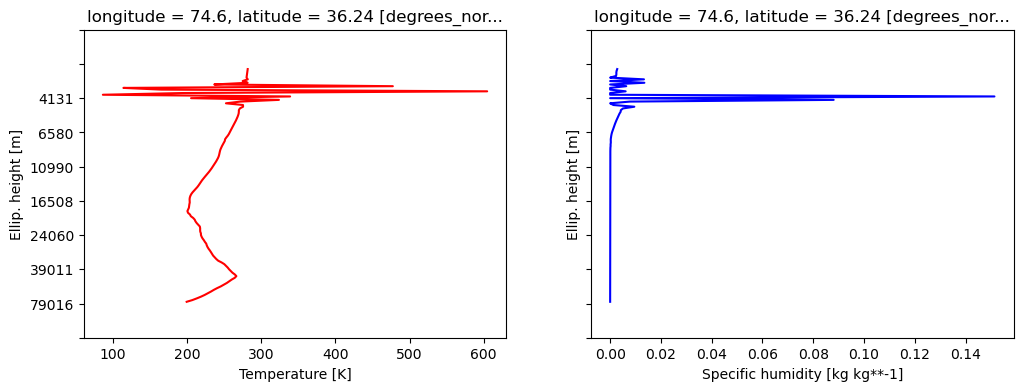

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharey=True)
center_ds = ds.isel(time=0).isel(longitude=int(np.rint(np.mean([lon_max, lon_min]))),
                       latitude=int(np.rint(np.mean([lat_max, lat_min]))))

center_ds.t.plot(ax=ax[0], color='red', y='level')
center_ds.q.plot(ax=ax[1], color='blue', y='level')
for a in ax:
    # Get current y-tick positions (model levels as ints)
    tick_levels = a.get_yticks()
    tick_levels = tick_levels.astype(int)
    print(tick_levels)

    # Convert model levels to height (hgt must be indexable by level)
    try:
        height_labels = [f"{hgt[lev]:.0f}" if 0 <= lev < len(hgt) else "" for lev in tick_levels]
    except Exception as e:
        print("Error mapping heights:", e)
        height_labels = [str(lev) for lev in tick_levels]

    # Apply new height labels
    a.set_yticks(tick_levels)
    a.set_yticklabels(height_labels)

    # Invert y-axis for atmospheric profile
    a.invert_yaxis()
    a.set_ylabel("Ellip. height [m]")

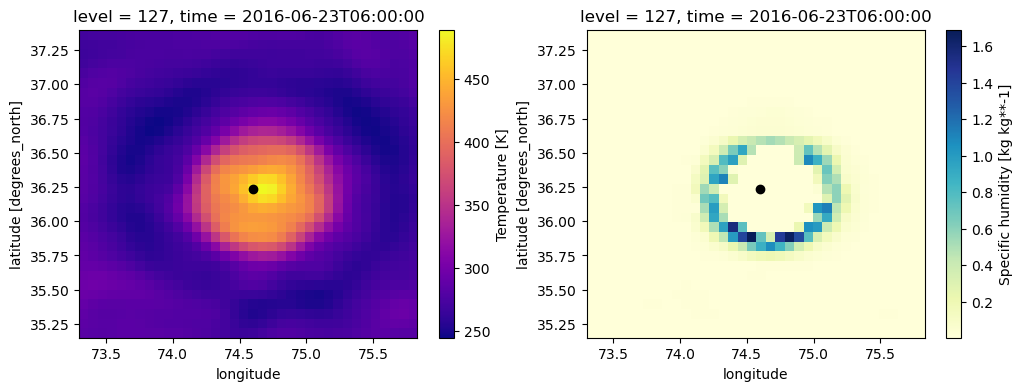

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
ds.t.isel(time=0, level=126).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=ax[0], cmap='plasma')
ds.q.isel(time=0, level=126).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=ax[1], cmap='YlGnBu')
for a in ax:
    a.plot(center_ds.longitude, center_ds.latitude, 'ko')

In [12]:
hgt[120:127]

array([4131.402 , 4081.7957, 4054.5466, 3982.8577, 3916.2002, 3894.1567,
       3852.0469], dtype=float32)

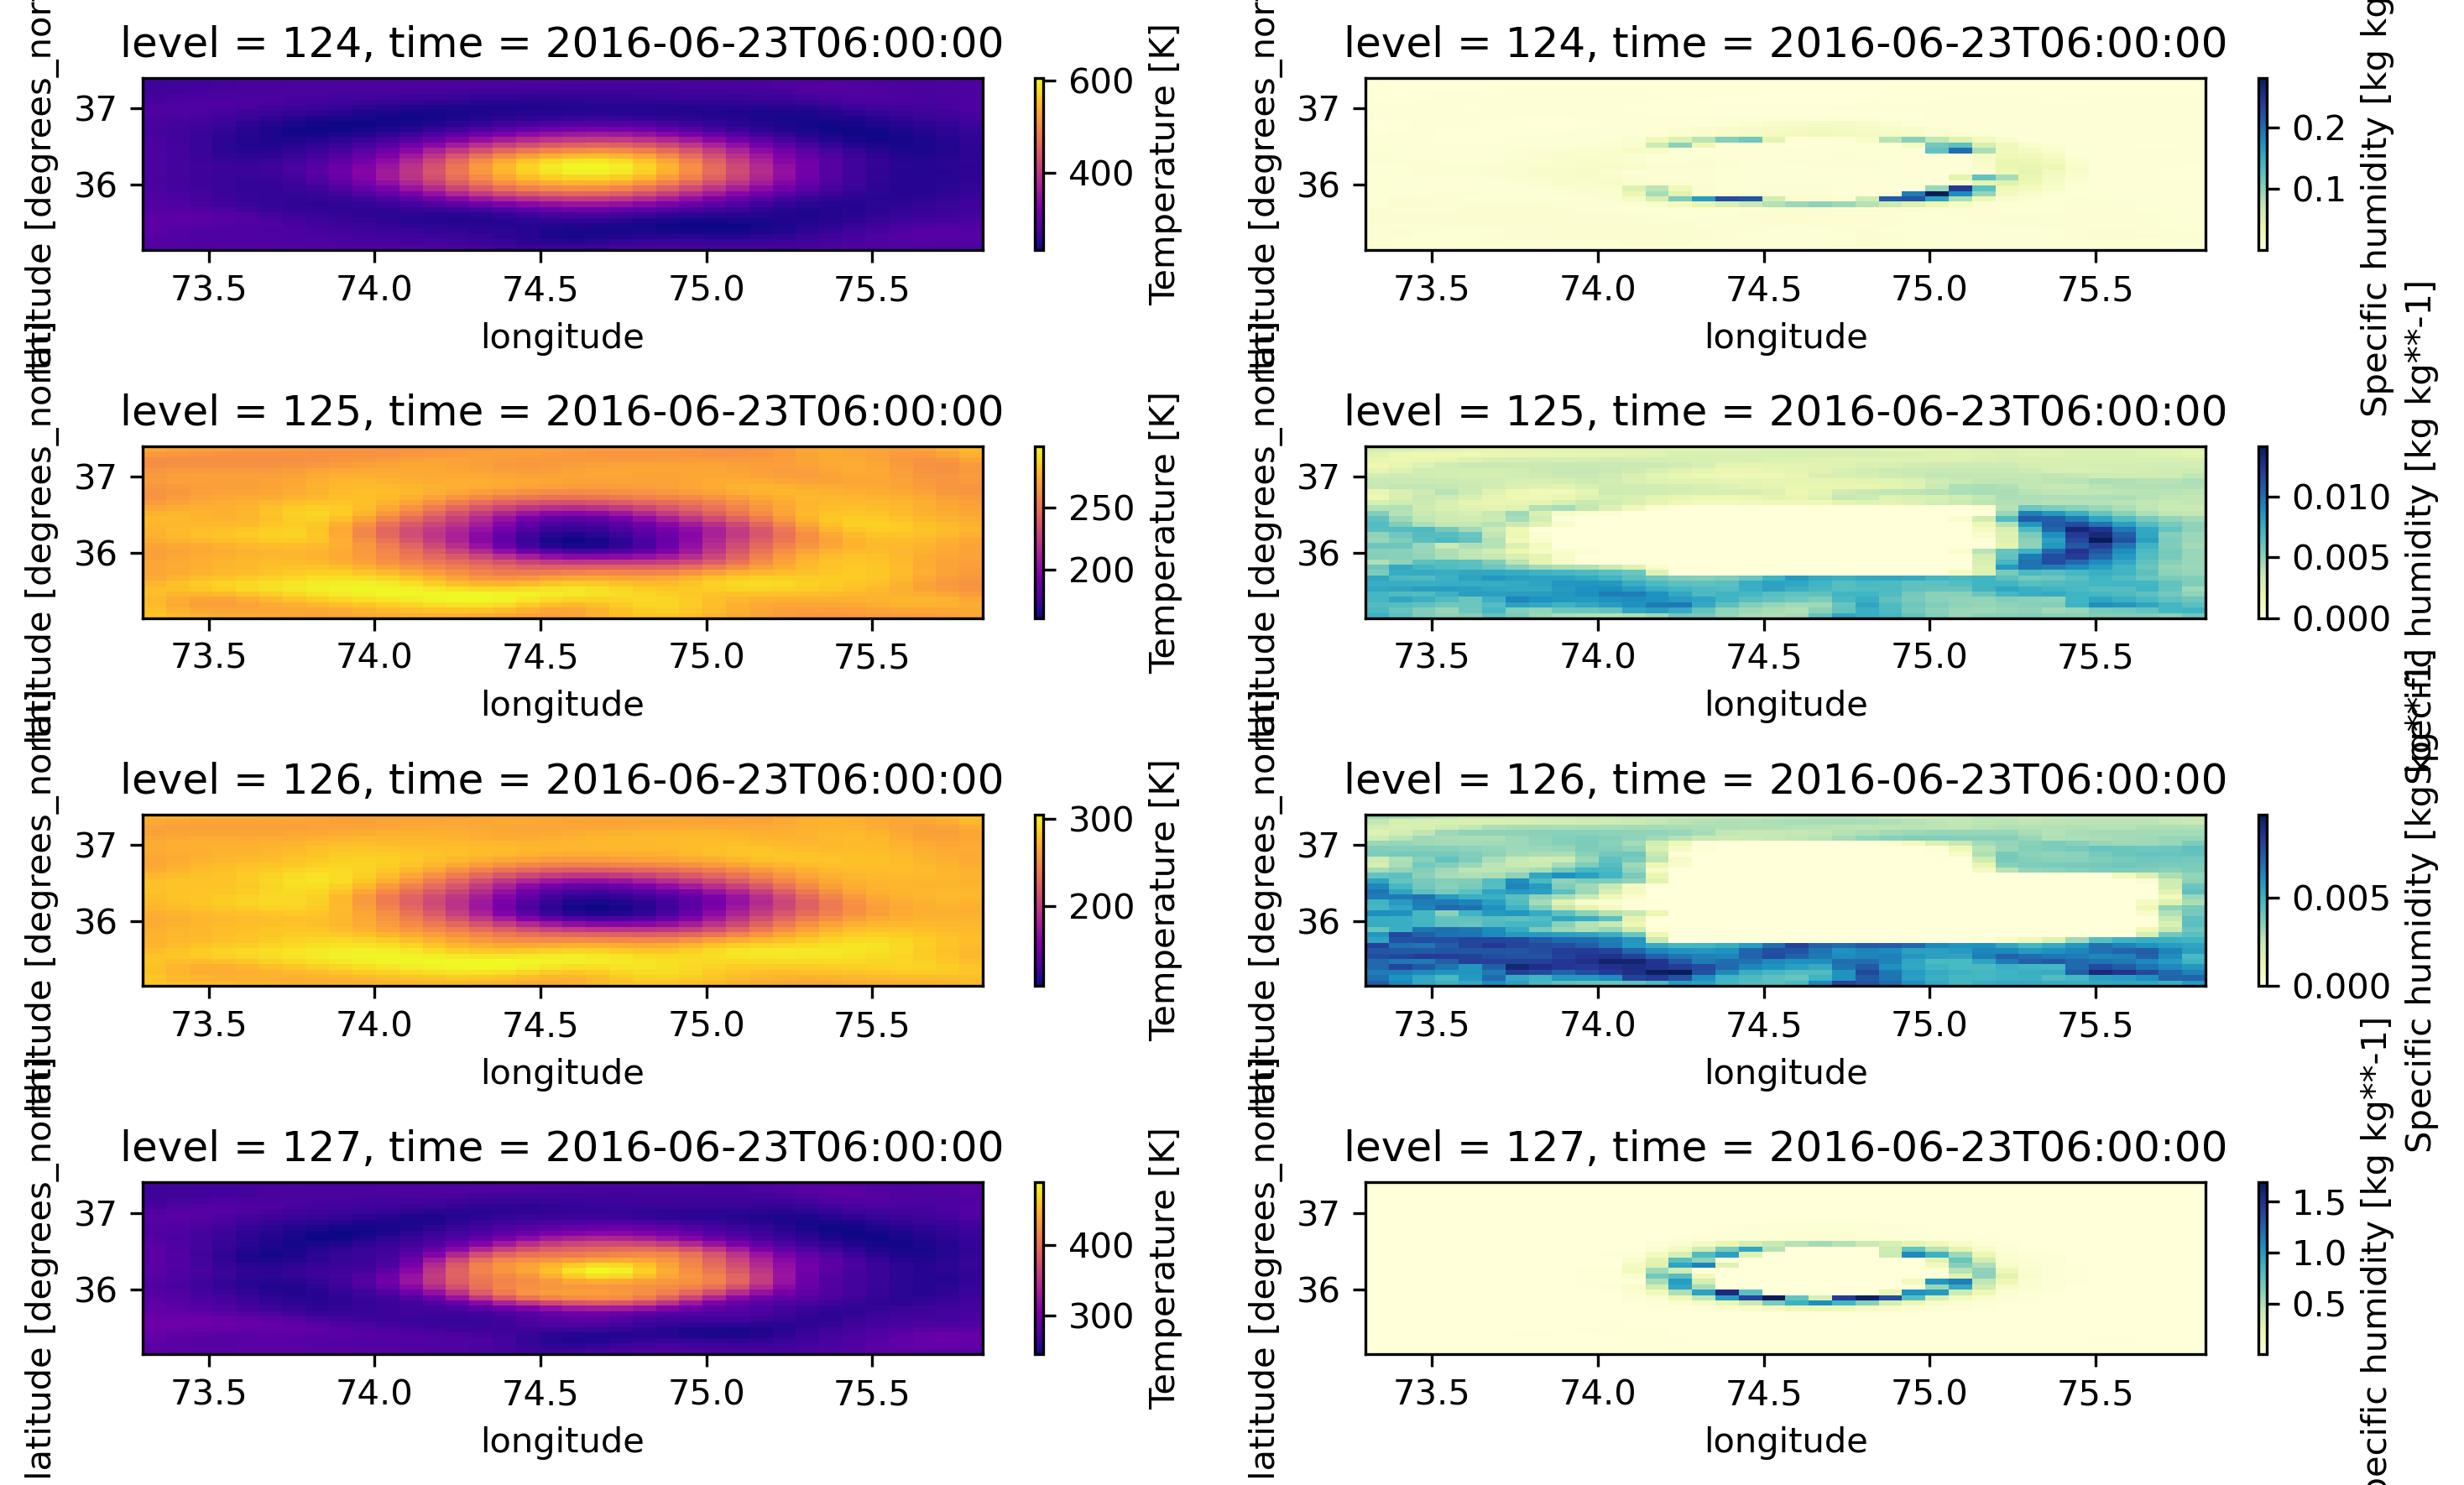

In [13]:
fig, ax = plt.subplots(4,2, figsize=(10,6),dpi=300)
for a, level in zip(ax, [123,124,125,126]):
    ds.t.isel(time=0, level=level).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=a[0], cmap='plasma')
    ds.q.isel(time=0, level=level).isel(longitude=lon_slice, latitude=lat_slice).plot.imshow(ax=a[1], cmap='YlGnBu')
plt.tight_layout()
plt.show()

## ZTD

In [60]:
ds = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/data/ECMWF_TROP_201606230600_201606230600_1.nc', chunks={})
ds = checks.validate_input(ds)
subset_ds= ds.isel(longitude=lon_slice, latitude=lat_slice)

   Variable "q" is out of valid range (0.0, 0.3): min = -0.00001 [<0.0],max = 1.69043 [>0.3]
   Variable "t" is out of valid range (140.0, 360.0): min = 82.57539 [<140.0],max = 606.28271 [>360.0]


In [61]:
ds.t.attrs

{'units': 'K', 'long_name': 'Temperature', 'standard_name': 'air_temperature'}

In [62]:
checks.get_min_max_nan(subset_ds['q'])

(0.0, 0.29833984375, 73)

In [63]:
checks.get_min_max_nan(subset_ds['t'])

(140.07537841796875, 359.4076843261719, 383)

In [64]:
out= calculate_ztd(subset_ds)
out = out.compute()

In [65]:

checks.get_min_max_nan(out['wet_delay'])

(-5.117617547512054e-07, 2.841796875, 0)

In [66]:
checks.get_min_max_nan(out['hydrostatic_delay'])

(0.0, 2.33935546875, 0)

In [67]:
out.wet_delay.min()

<xarray.DataArray 'wet_delay' ()> Size: 4B
array(-5.1176175e-07, dtype=float32)
Coordinates:
    spatial_ref  int64 8B 0

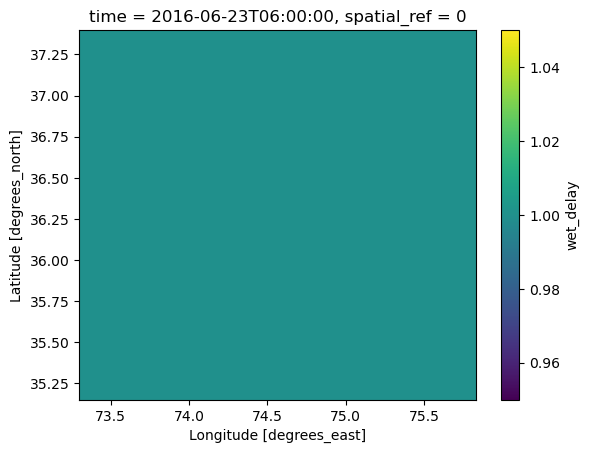

In [56]:
%matplotlib inline
mask = (out.wet_delay >= 0).any(dim='height')
mask.isel(time=0).astype(int).plot.imshow(cmap='viridis')
#out.wet_delay.where(out.wet_delay>=0, np.nan).isel(time=0, height=0).plot.imshow()
plt.show()

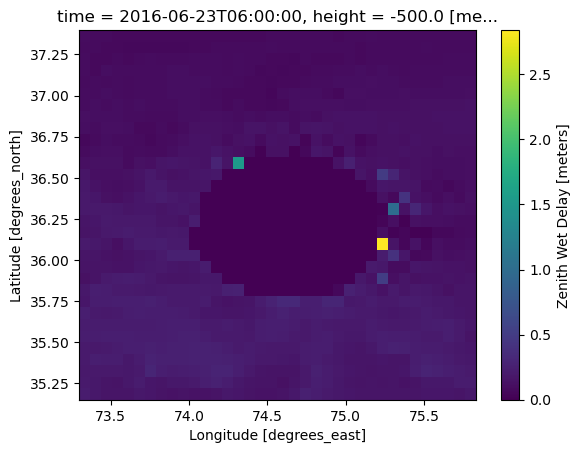

In [68]:
out.wet_delay.where(out.wet_delay>=0, np.nan).isel(time=0, height=0).plot.imshow()

# Get DEM

In [14]:
subset_ds= ds.isel(longitude=lon_slice, latitude=lat_slice)

In [15]:
from dem_stitcher import stitch_dem
import pyproj

# Get DISP extent in latitude/longitude
min_lon, min_lat = subset_ds.longitude.min().values, subset_ds.latitude.min().values
max_lon, max_lat = subset_ds.longitude.max().values , subset_ds.latitude.max().values

# load DEM and incidence angle
dem, p = stitch_dem([min_lon, min_lat, max_lon, max_lat],
                  dem_name='glo_90',  # Global Copernicus 90 meter resolution DEM
                  dst_ellipsoidal_height=True, # OPERA tropo is in elliposidal heights
                  dst_area_or_point='Point')

Reading tile imagery: 100%|██████████| 9/9 [00:01<00:00,  6.36it/s]


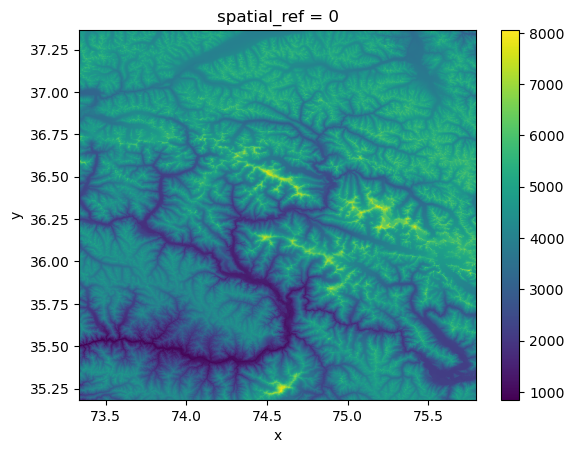

In [16]:
# Define metadata
width, height = p['width'], p['height']
transform = p['transform']
nodata_value = np.nan

# Generate coordinates
x = np.linspace(transform.c, transform.c + transform.a * (width - 1), width)
y = np.linspace(transform.f, transform.f + transform.e * (height - 1), height)

dem_ds = xr.DataArray(dem, dims=("y", "x"),
                     coords={"x": x, "y": y},
                     attrs={"crs": "EPSG:4326", "nodata": nodata_value}
                     )
dem_ds = dem_ds.rio.write_crs('EPSG:4326', inplace=True)
del dem
dem_ds.plot.imshow()

In [17]:
mask = subset_ds.t.isel(time=0, level=126) > 400

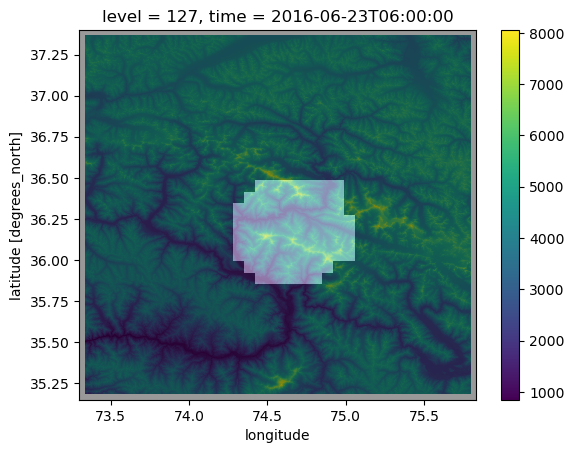

In [18]:
fig, ax = plt.subplots()
dem_ds.plot.imshow(ax=ax)
mask.plot.imshow(ax=ax, cmap='gray', alpha=0.4, add_colorbar=False)

In [19]:
# Stack mask to get matching lat/lon pairs
mask = mask.compute()
points = mask.stack(points=('latitude', 'longitude'))
points_true = points.where(points, drop=True)

# Extract matching lat/lon pairs
lat_vals = points_true['latitude'].values
lon_vals = points_true['longitude'].values

# Select DEM values at these points using .sel with vectorized input
dem_values = dem_ds.sel(y=xr.DataArray(lat_vals, dims='points'),
                        x=xr.DataArray(lon_vals, dims='points'),
                        method='nearest')

# Compute stats
dem_min = dem_values.min().item()
dem_mean = dem_values.mean().item()
dem_max = dem_values.max().item()

print(dem_min, dem_mean, dem_max)

1424.642578125 3904.879150390625 6407.60546875


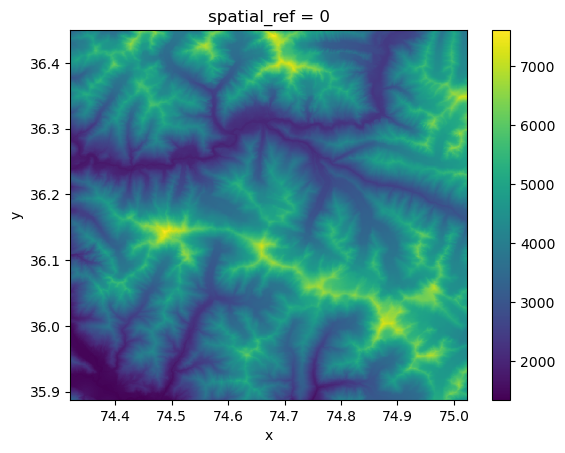

In [20]:
dem_ds.sel(x=slice(np.min(lon_vals), np.max(lon_vals)),
           y=slice(np.max(lat_vals), np.min(lat_vals))).plot.imshow()

In [21]:
dem_ds.sel(y=center_ds.latitude, x=center_ds.longitude, method='nearest')

<xarray.DataArray ()> Size: 4B
array(3547.3086, dtype=float32)
Coordinates:
    x            float64 8B 74.6
    y            float64 8B 36.24
    spatial_ref  int64 8B 0
    longitude    float32 4B 74.6
    latitude     float32 4B 36.24
    time         datetime64[ns] 8B 2016-06-23T06:00:00
Attributes:
    nodata:   nan

# Calculate ZTD

In [37]:
import numpy as np
import xarray as xr
from scipy.interpolate import RegularGridInterpolator

def interpolate_3d(data_xs, data_ys, data_zs, data_ws, interpolation_points, fill_value=None, assume_sorted=False):
    if not assume_sorted:
        sorted_x = np.argsort(data_xs)
        sorted_y = np.argsort(data_ys)
        sorted_z = np.argsort(data_zs)
        data_xs = np.array(data_xs)[sorted_x]
        data_ys = np.array(data_ys)[sorted_y]
        data_zs = np.array(data_zs)[sorted_z]
        data_ws = np.array(data_ws)[np.ix_(sorted_x, sorted_y, sorted_z)]

    interpolator = RegularGridInterpolator(
        (data_xs, data_ys, data_zs),
        data_ws,
        method='linear',  # 'cubic' often fails in edge cases
        bounds_error=False,
        fill_value=fill_value
    )
    return interpolator(interpolation_points)

def interp_with_dem2(dem_xr, tropo_xr):
    # DEM extent
    min_x, min_y, max_x, max_y = dem_xr.rio.bounds()
    min_height = float(dem_xr.min())
    max_height = float(dem_xr.max())

    # Slice tropo cube around DEM bounds
    isel = dict(
        longitude=slice(min_x - 0.2, max_x + 0.2),
        latitude=slice(max_y + 0.2, min_y - 0.2),  # reversed lat order
        height=slice(min_height - 1000, max_height + 1000)
    )

    # Subset and interpolate tropo cube to DEM horizontal grid
    tropo_ds = tropo_xr.sel(isel).interp(
        longitude=dem_xr.x, latitude=dem_xr.y, method="linear"
    )

    # Create 3D interpolation points: (N, 3)
    X, Y = np.meshgrid(dem_xr.x, dem_xr.y, indexing="xy")
    Z = dem_xr.values  # DEM surface elevations
    interp_points = np.column_stack([Y.ravel(), X.ravel(), Z.ravel()])  # (lat, lon, height)

    # Interpolate
    values = interpolate_3d(
        data_xs=tropo_ds.y.values,
        data_ys=tropo_ds.x.values,
        data_zs=tropo_ds.height.values,
        data_ws=tropo_ds.transpose("y", "x", "height").values,
        interpolation_points=interp_points
    )

    # Return interpolated 2D field as DataArray
    da = xr.DataArray(values.reshape(dem_xr.shape), dims=("y", "x"),
                      coords={"y": dem_xr.y, "x": dem_xr.x})
    return da.rio.write_crs("EPSG:4326")


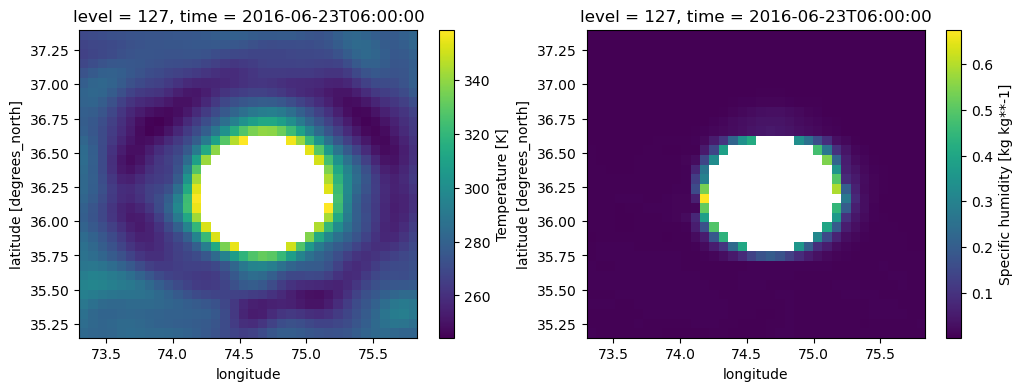

In [23]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
subset_ds.where(subset_ds.t<360).isel(time=0, level=126).t.plot.imshow(ax=ax[0])
subset_ds.where(subset_ds.t<360).isel(time=0, level=126).q.plot.imshow(ax=ax[1])

## with Extreme values

In [51]:
out= calculate_ztd(subset_ds)
out = out.compute()

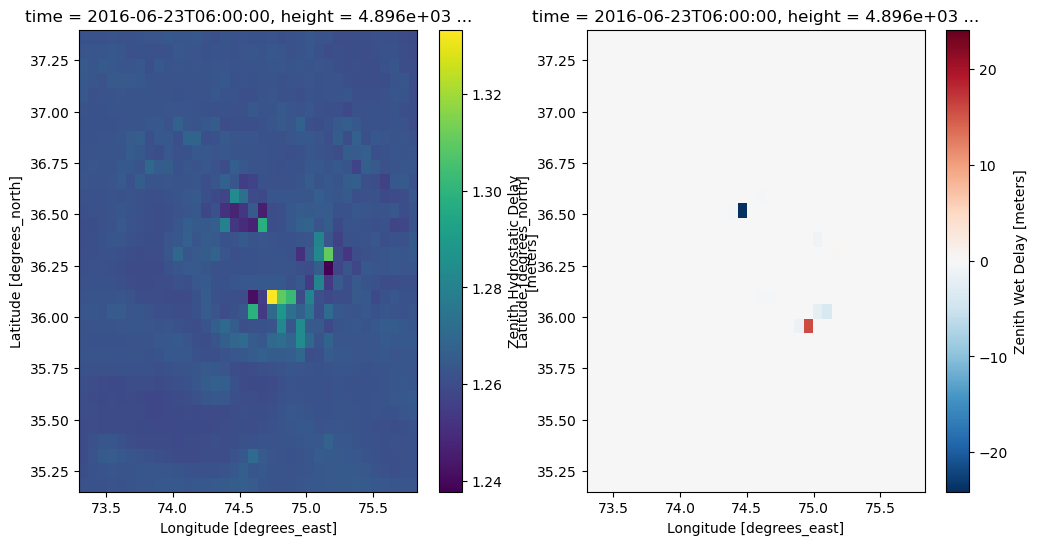

In [58]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out.hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out.wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

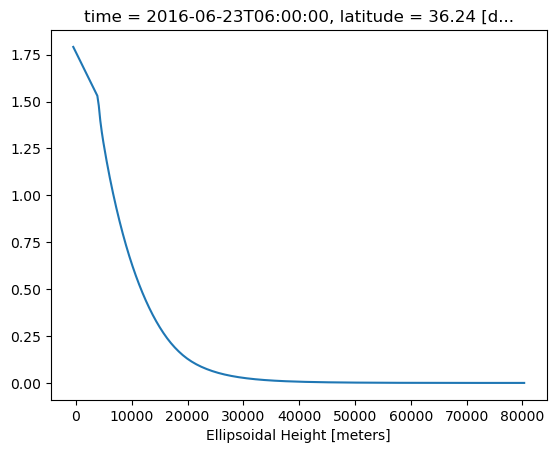

In [162]:
ztd.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot()

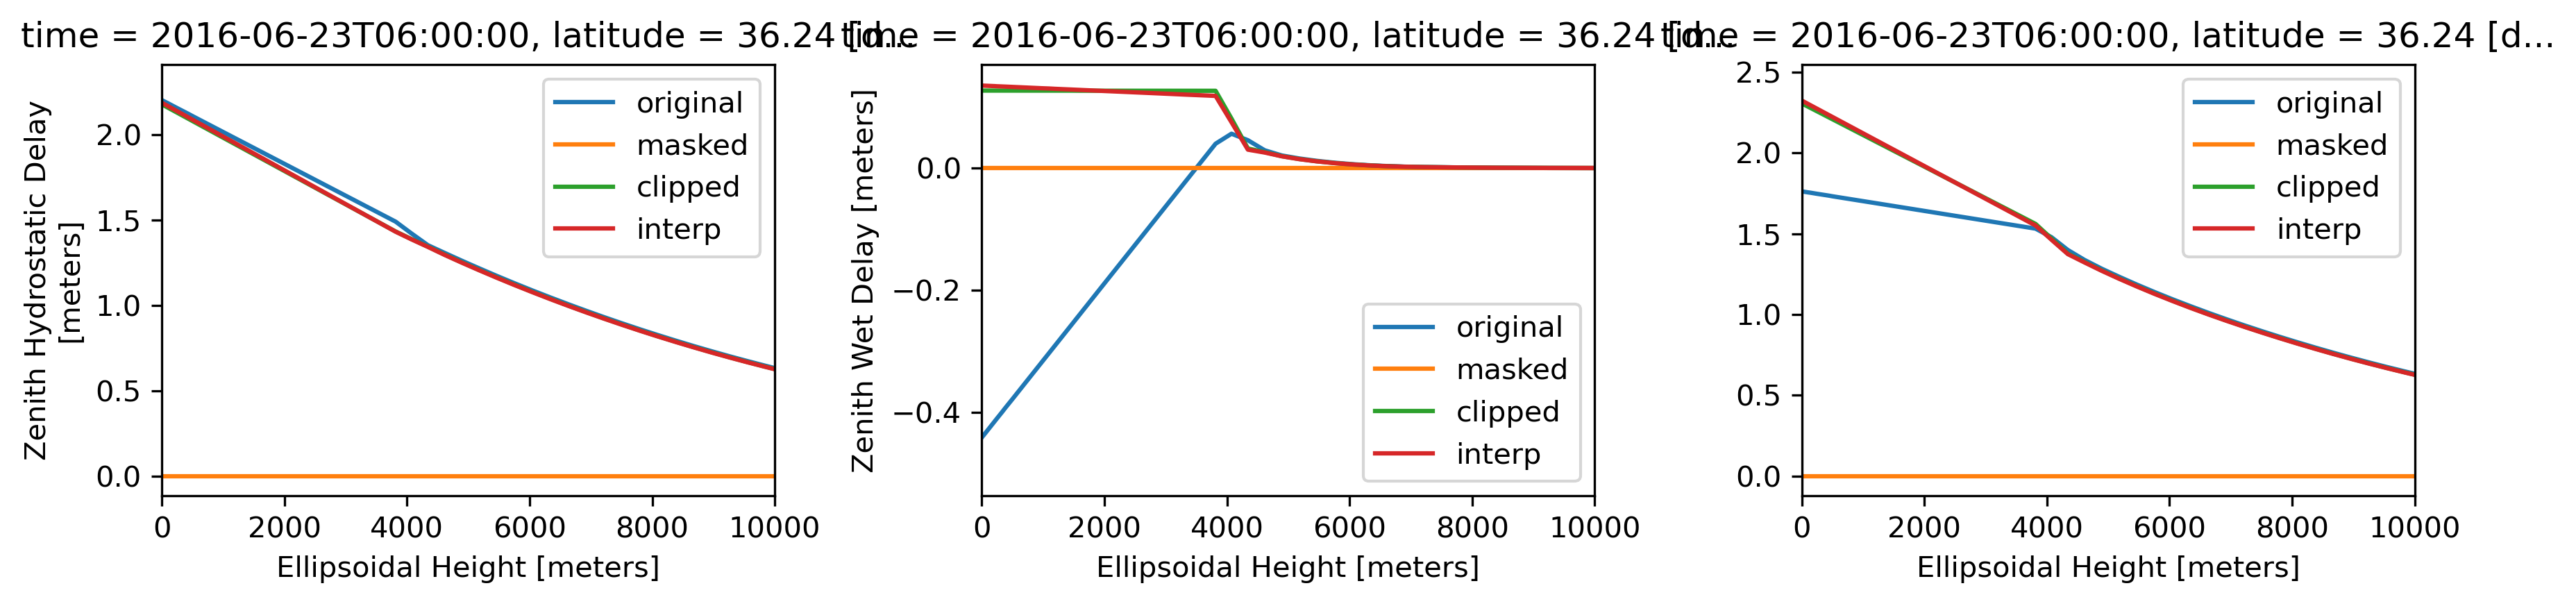

In [169]:
fig, ax = plt.subplots(1,3, figsize=(12,3), dpi=300)
out.hydrostatic_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[0], label='original')
out.wet_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[1], label='original')
ztd.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[2], label='original')
out_masked.hydrostatic_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[0],label='masked')
out_masked.wet_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude, method='nearest').plot(ax=ax[1], label='masked')
ztd_mask.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[2], label='masked')
out_clip.hydrostatic_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[0],label='clipped')
out_clip.wet_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[1], label='clipped')
ztd_clip.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[2], label='clipped')
out_interp.hydrostatic_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[0],label='interp')
out_interp.wet_delay.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[1], label='interp')
ztd_interp.isel(time=0).sel(longitude=center_ds.longitude, latitude=center_ds.latitude).plot(ax=ax[2], label='interp')
for a in ax: a.set_xlim(0,10000), a.legend()
plt.tight_layout()

In [64]:
ztd = out.hydrostatic_delay + out.wet_delay
tropo_ztd = interp_with_dem2(dem_ds, ztd.isel(time=0))

Text(0.5, 1.0, 'ZTD')

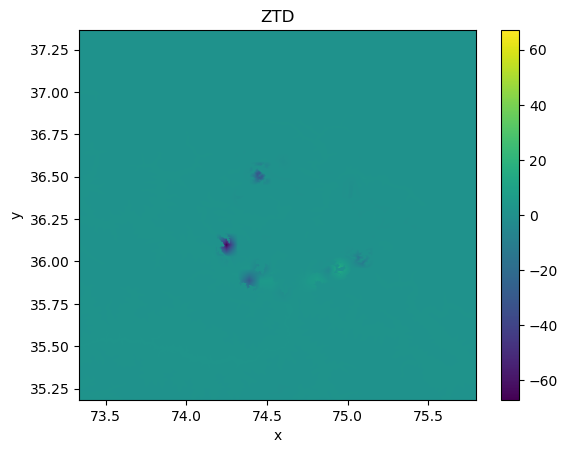

In [66]:
fig, ax = plt.subplots()
tropo_ztd.plot.imshow(ax=ax, cmap='viridis')
ax.set_title('ZTD')

## 1. Mask

In [61]:
out_masked = calculate_ztd(subset_ds.where(subset_ds.t<360))
out_masked = out_masked.compute()

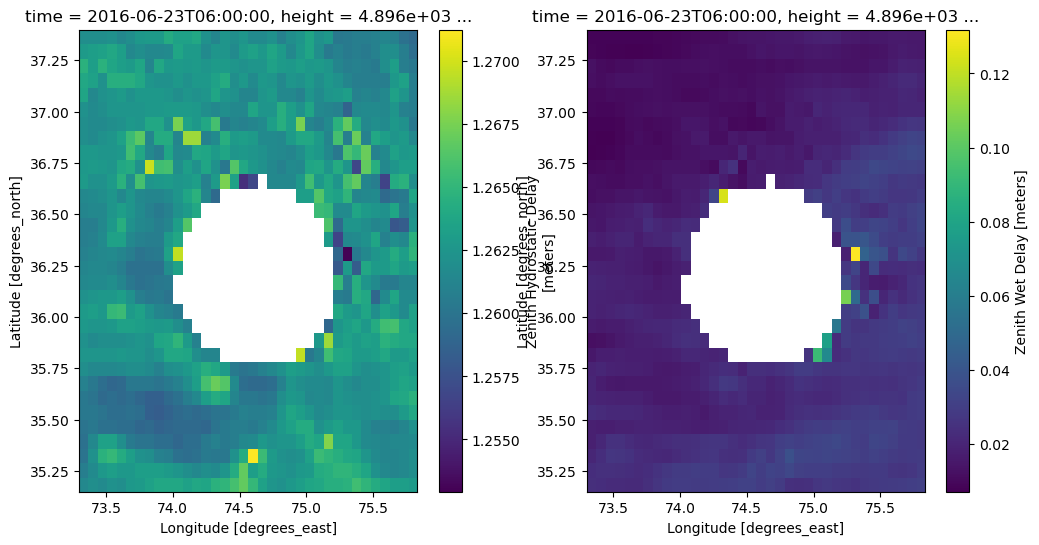

In [62]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out_masked.where(out_masked.hydrostatic_delay >0).hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out_masked.where(out_masked.wet_delay >0).wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

In [63]:
ztd_mask = out_masked.hydrostatic_delay + out_masked.wet_delay
tropo_ztd_mask = interp_with_dem2(dem_ds, ztd_mask.isel(time=0))

Text(0.5, 1.0, 'ZTD_mask')

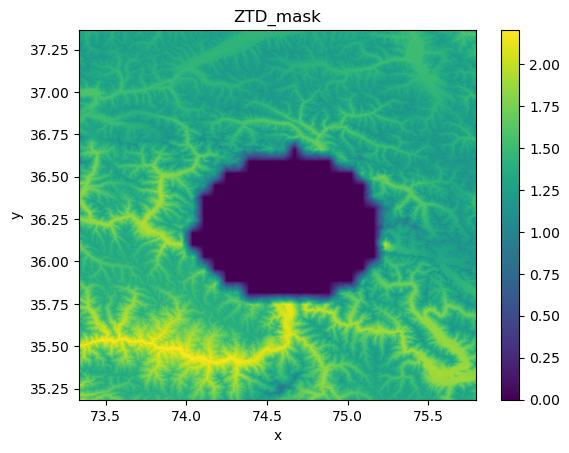

In [135]:
fig, ax = plt.subplots()
tropo_ztd_mask.plot.imshow(ax=ax)
ax.set_title('ZTD_mask')

## 2. Clip

In [47]:
subset_ds_clip = subset_ds.copy()
subset_ds_clip['t'] = subset_ds.t.where(subset_ds.t<360, 360)
subset_ds_clip['q'] = subset_ds.q.where(subset_ds.q<0.3, 0.3)
out_clip = calculate_ztd(subset_ds_clip)
out_clip = out_clip.compute()

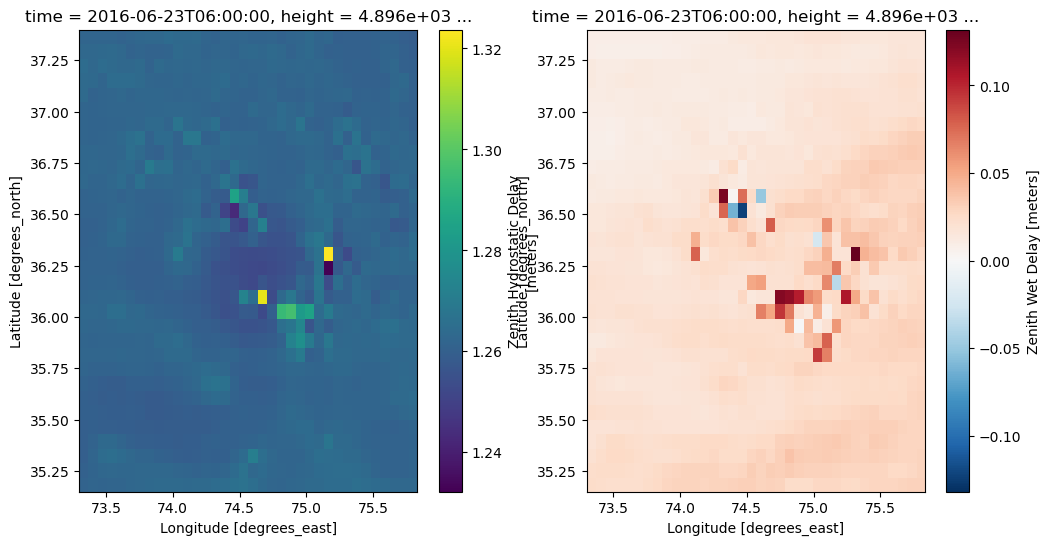

In [48]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out_clip.hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out_clip.wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

In [49]:
ztd_clip = out_clip.hydrostatic_delay + out_clip.wet_delay
tropo_ztd_clip = interp_with_dem2(dem_ds, ztd_clip.isel(time=0))

Text(0.5, 1.0, 'ZTD_mask')

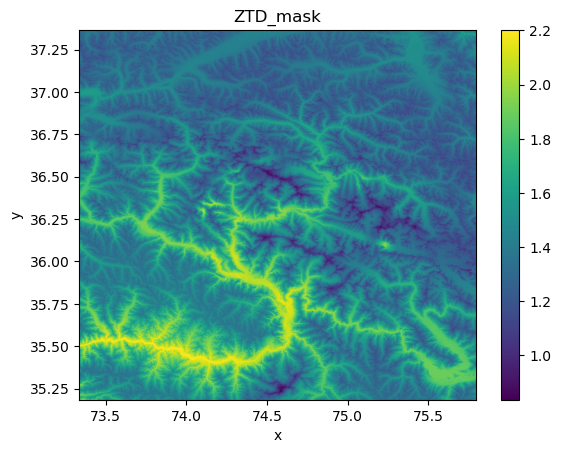

In [134]:
fig, ax = plt.subplots()
tropo_ztd_clip.plot.imshow(ax=ax)
ax.set_title('ZTD_clip')

## 3. Interpolate

In [87]:
def interpolate_na_outside_per_level(
    ds: xr.Dataset,
    var: str,
    threshold: float,
    above: bool = True
) -> xr.DataArray:
    """
    Interpolates NaNs in `var` per level where values are above or below threshold.

    Parameters:
    - ds: xarray.Dataset
    - var: variable name
    - threshold: threshold value for masking
    - above: if True, interpolate where values are below or equal threshold; else above or equal

    Returns:
    - Interpolated DataArray with same dims as ds[var]
    """

    def interp_slice(da_slice):
        # da_slice is a DataArray with dims without 'level' (a single level slice)
        mask = da_slice <= threshold if above else da_slice >= threshold

        interp = (
            da_slice.where(mask)
            .sortby('latitude')
            .chunk({'latitude': -1, 'longitude': -1})
            .interpolate_na(dim='latitude', method='linear')
            .interpolate_na(dim='longitude', method='linear')
            .sortby('latitude', ascending=False)
        )
        return interp

    # Apply per level slice, combine back automatically
    interpolated = ds[var].groupby('level').map(interp_slice)

    return interpolated 

def interpolate_na_outside(
    ds: xr.Dataset,
    var: str,
    threshold: float,
    above: bool = True
) -> xr.DataArray:
    """
    Interpolates NaNs in `var` per level where values are above or below threshold.

    Parameters:
    - ds: xarray.Dataset
    - var: variable name
    - threshold: threshold value for masking
    - above: if True, interpolate where values are below or equal threshold; else above or equal

    Returns:
    - Interpolated DataArray with same dims as ds[var]
    """
    da_slice = ds[var]

    # da_slice is a DataArray with dims without 'level' (a single level slice)
    mask = da_slice <= threshold if above else da_slice >= threshold

    return (
            da_slice.where(mask)
            .sortby('latitude')
            .chunk({'latitude': -1, 'longitude': -1})
            .interpolate_na(dim='latitude', method='linear')
            .interpolate_na(dim='longitude', method='linear')
            .sortby('latitude', ascending=False)
        )

In [88]:
subset_ds_interp = subset_ds.copy()
subset_ds_interp['t'] = interpolate_na_outside(subset_ds, 't', 350)
subset_ds_interp['q'] = interpolate_na_outside(subset_ds, 'q', 0.3)

In [85]:
subset_ds_interp_l = subset_ds.copy()
subset_ds_interp_l['t'] = interpolate_na_outside_per_level(subset_ds, 't', 350)
subset_ds_interp_l['q'] = interpolate_na_outside_per_level(subset_ds, 'q', 0.3)

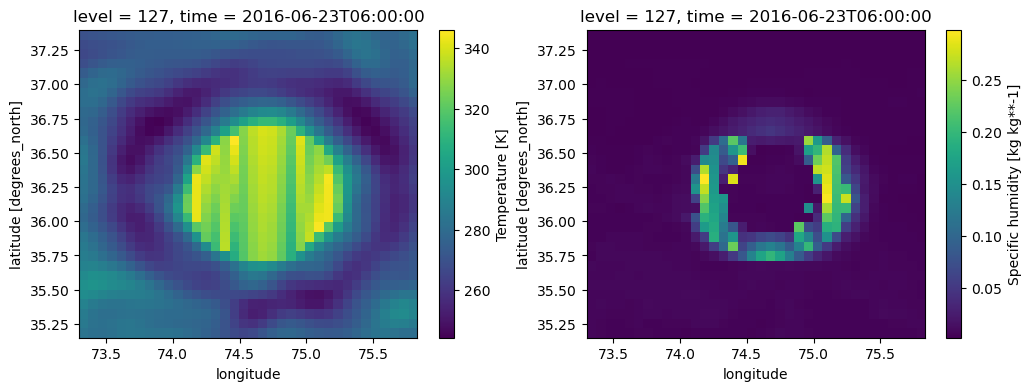

In [89]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
subset_ds_interp.t.isel(time=0, level=126).plot.imshow(ax=ax[0])
subset_ds_interp.q.isel(time=0, level=126).plot.imshow(ax=ax[1])

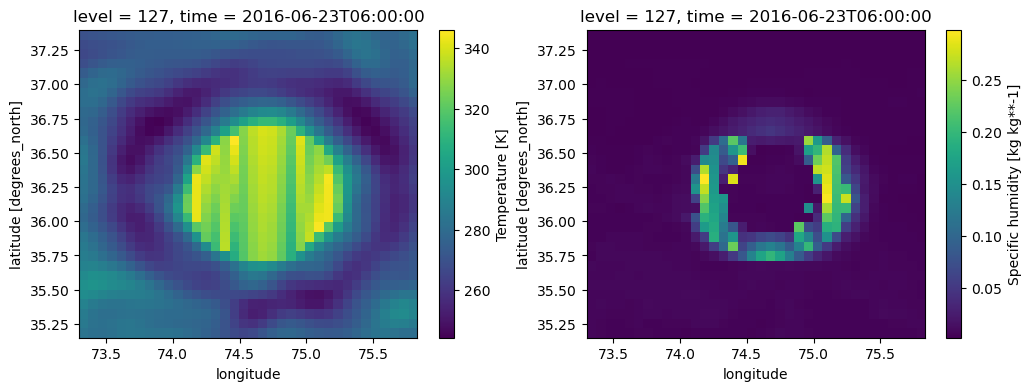

In [86]:
fig, ax = plt.subplots(1,2, figsize=(12,4))
subset_ds_interp_l.t.isel(time=0, level=126).plot.imshow(ax=ax[0])
subset_ds_interp_l.q.isel(time=0, level=126).plot.imshow(ax=ax[1])

In [73]:
out_interp = calculate_ztd(subset_ds_interp)
out_interp = out_interp.compute()

In [119]:
out_interp_l = calculate_ztd(subset_ds_interp_l)
out_interp_l = out_interp_l.compute()

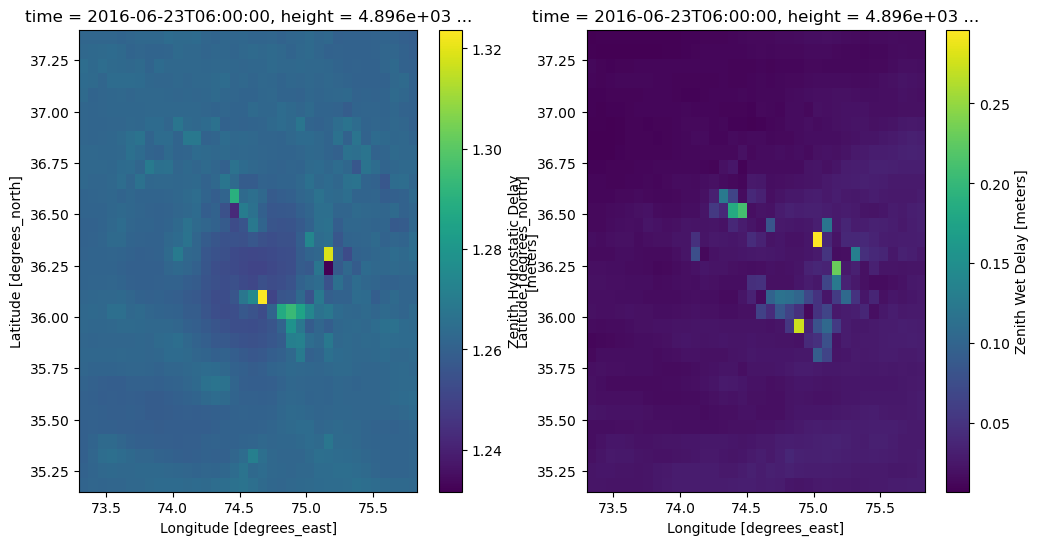

In [74]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out_interp.hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out_interp.wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

In [ ]:
ztd_interp = out_interp.hydrostatic_delay + out_interp.wet_delay
tropo_ztd_interp = interp_with_dem2(dem_ds, ztd_interp.isel(time=0))

Text(0.5, 1.0, 'ZTD interp')

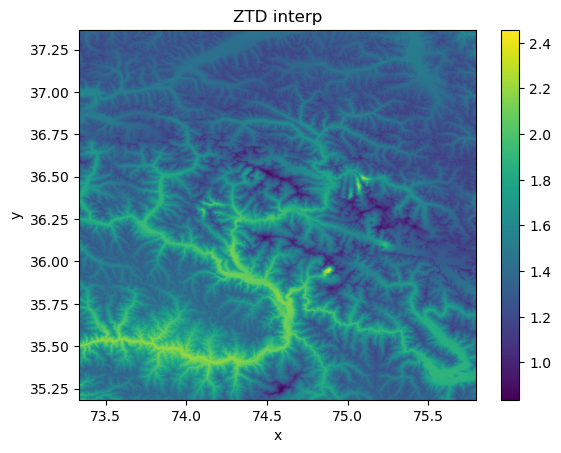

In [133]:
fig, ax = plt.subplots()
tropo_ztd_interp.plot.imshow(ax=ax)
ax.set_title('ZTD interp')

In [120]:
ztd_interp_l = out_interp_l.hydrostatic_delay + out_interp_l.wet_delay
tropo_ztd_interp_l = interp_with_dem2(dem_ds, ztd_interp_l.isel(time=0))

Text(0.5, 1.0, 'Difference')

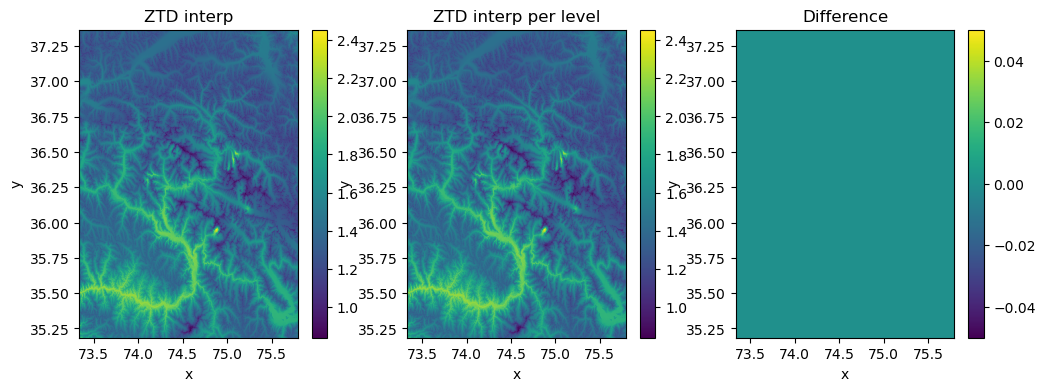

In [122]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd_interp.plot.imshow(ax=ax[0])
tropo_ztd_interp_l.plot.imshow(ax=ax[1])
(tropo_ztd_interp-tropo_ztd_interp_l).plot.imshow(ax=ax[2])
ax[0].set_title('ZTD interp')
ax[1].set_title('ZTD interp per level')
ax[2].set_title('Difference')

### Difference between clipping and interpolation

Text(0.5, 1.0, 'difference')

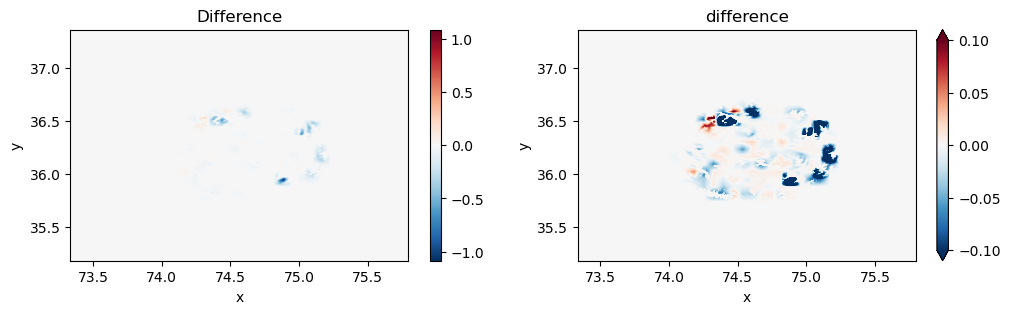

In [173]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
(tropo_ztd_clip - tropo_ztd_interp).plot.imshow(ax=ax[0])
(tropo_ztd_clip - tropo_ztd_interp).plot.imshow(ax=ax[1], vmin=-0.1, vmax=0.1, cmap='RdBu_r')
ax[0].set_title('Difference')
ax[1].set_title('difference')

Text(0.5, 1.0, 'Difference')

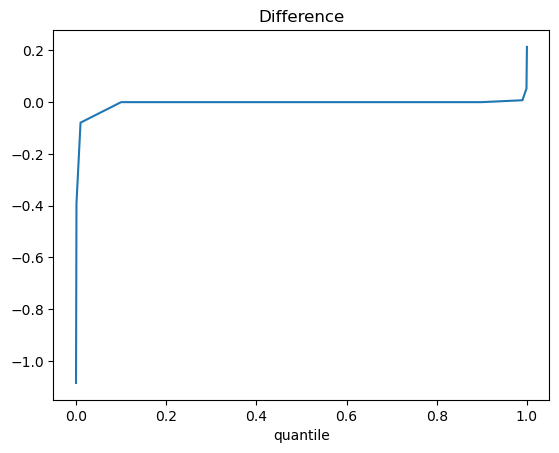

In [174]:
(tropo_ztd_clip - tropo_ztd_interp).quantile([0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 1]).plot()
plt.title("Difference")

# Compare with nearby dates

In [95]:
ds1 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/download_test/ECMWF_TROP_201606220600_201606220600_1.nc', chunks={})
ds2 = xr.open_dataset('/u/aurora-r0/govorcin/01_OPERA/TROPO/download_test/ECMWF_TROP_201606240600_201606240600_1.nc', chunks={})

In [96]:
subset_ds1 = ds1.isel(longitude=lon_slice, latitude=lat_slice)
subset_ds2 = ds2.isel(longitude=lon_slice, latitude=lat_slice)

In [97]:
out1= calculate_ztd(subset_ds1)
out1 = out1.compute()
out2= calculate_ztd(subset_ds2)
out2 = out2.compute()

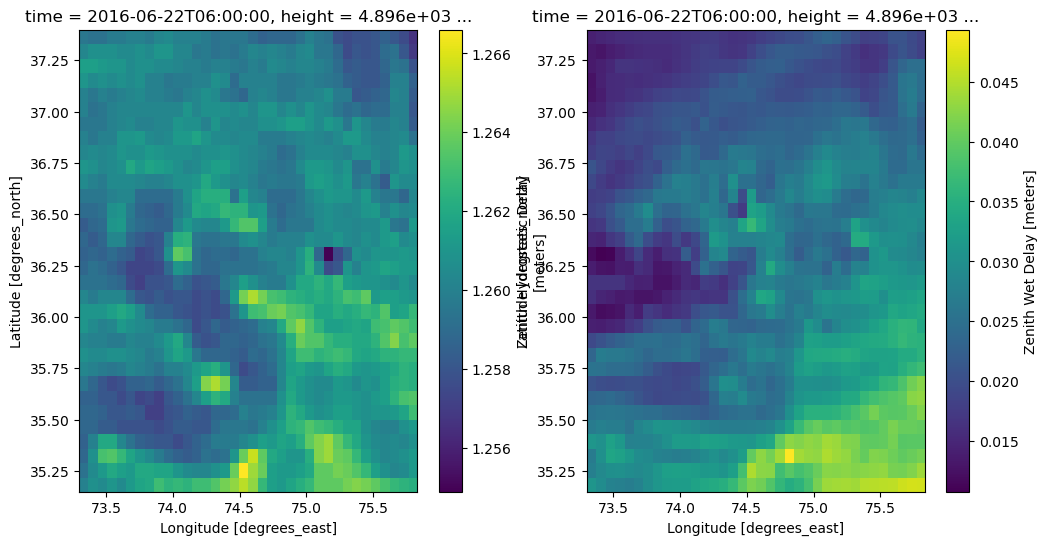

In [98]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out1.hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out1.wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

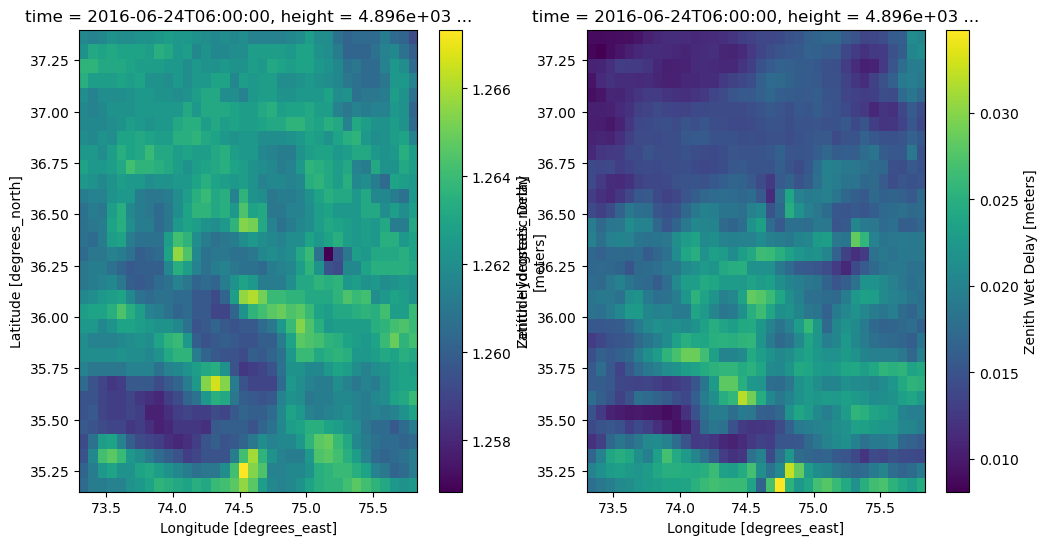

In [99]:
# Nanga Parbat
fig, ax =plt.subplots(1,2, figsize=(12,6))
out2.hydrostatic_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[0])
out2.wet_delay.isel(time=0).sel(height=5000, method='nearest').plot.imshow(ax=ax[1])

In [100]:
ztd1 = out1.hydrostatic_delay + out1.wet_delay
tropo_ztd1 = interp_with_dem2(dem_ds, ztd1.isel(time=0))

In [101]:
ztd2 = out2.hydrostatic_delay + out2.wet_delay
tropo_ztd2 = interp_with_dem2(dem_ds, ztd2.isel(time=0))

Text(0.5, 1.0, 'Difference')

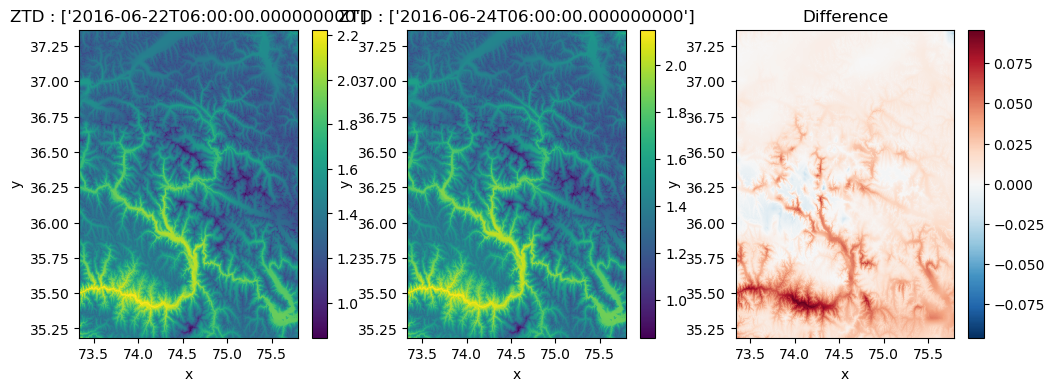

In [106]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd1.plot.imshow(ax=ax[0])
tropo_ztd2.plot.imshow(ax=ax[1])
(tropo_ztd1 - tropo_ztd2).plot.imshow(ax=ax[2])
ax[0].set_title(f'ZTD : {ztd1.time.values}')
ax[1].set_title(f'ZTD : {ztd2.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference')

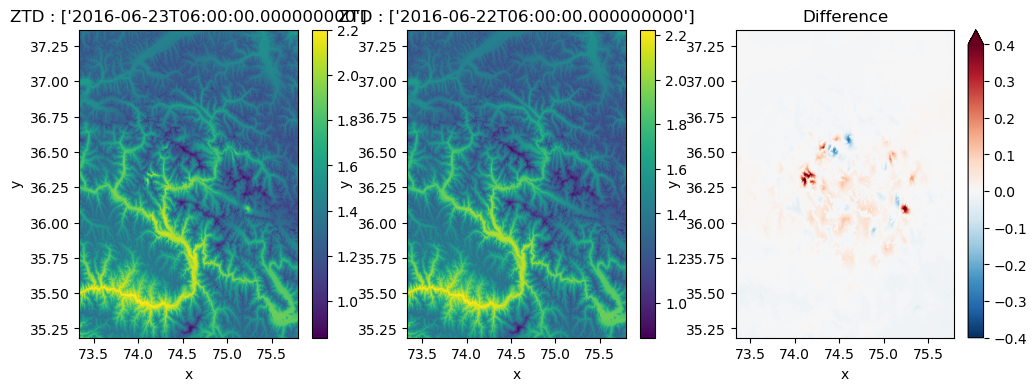

In [175]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd_clip.plot.imshow(ax=ax[0])
tropo_ztd1.plot.imshow(ax=ax[1])
(tropo_ztd_clip - tropo_ztd1).plot.imshow(ax=ax[2], vmin=-0.4, vmax=0.4, cmap='RdBu_r')
ax[0].set_title(f'ZTD : {ztd.time.values}')
ax[1].set_title(f'ZTD : {ztd1.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference quantile')

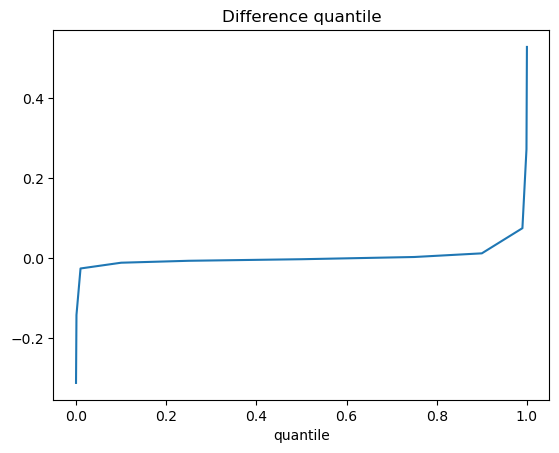

In [178]:
(tropo_ztd_clip - tropo_ztd1).quantile([0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 1]).plot()
plt.title('Difference quantile')

Text(0.5, 1.0, 'Difference')

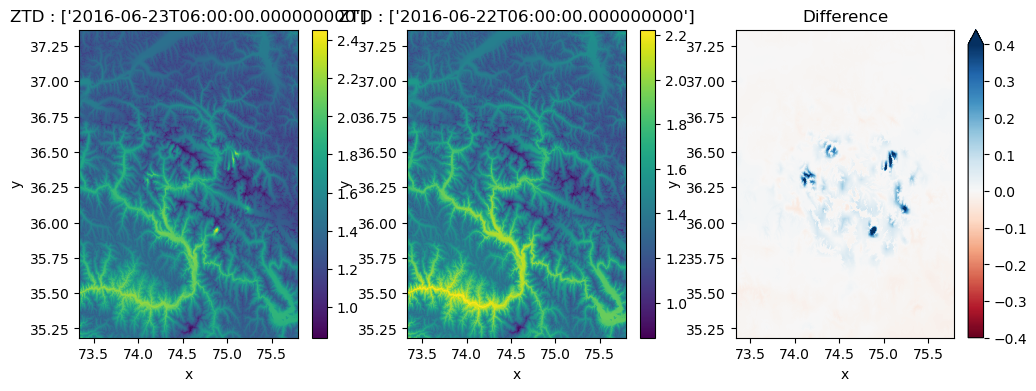

In [116]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd_interp.plot.imshow(ax=ax[0])
tropo_ztd1.plot.imshow(ax=ax[1])
(tropo_ztd_interp - tropo_ztd1).plot.imshow(ax=ax[2], vmin=-0.4, vmax=0.4, cmap='RdBu')
ax[0].set_title(f'ZTD : {ztd.time.values}')
ax[1].set_title(f'ZTD : {ztd1.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference quantile')

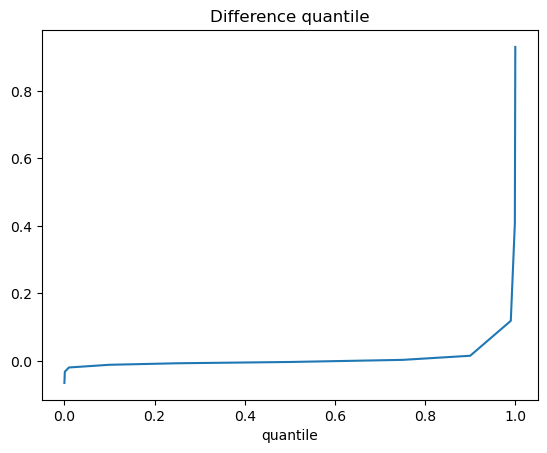

In [179]:
(tropo_ztd_interp - tropo_ztd1).quantile([0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 1]).plot()
plt.title('Difference quantile')

Text(0.5, 1.0, 'Difference')

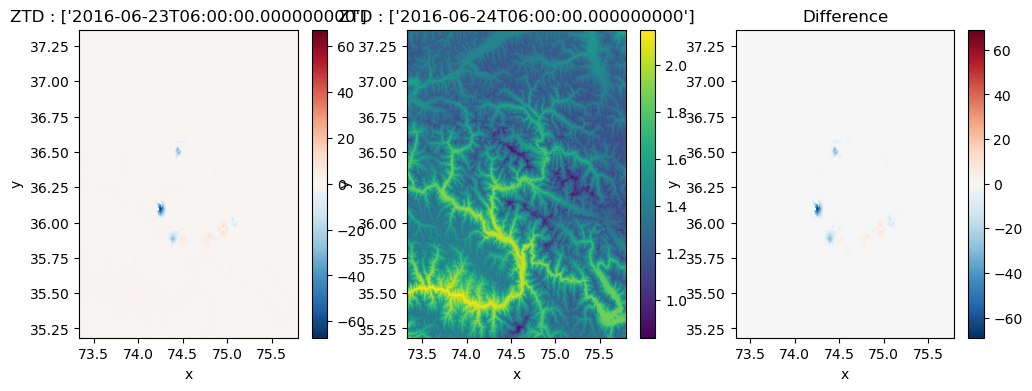

In [110]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd.plot.imshow(ax=ax[0])
tropo_ztd2.plot.imshow(ax=ax[1])
(tropo_ztd - tropo_ztd2).plot.imshow(ax=ax[2])
ax[0].set_title(f'ZTD : {ztd.time.values}')
ax[1].set_title(f'ZTD : {ztd2.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference')

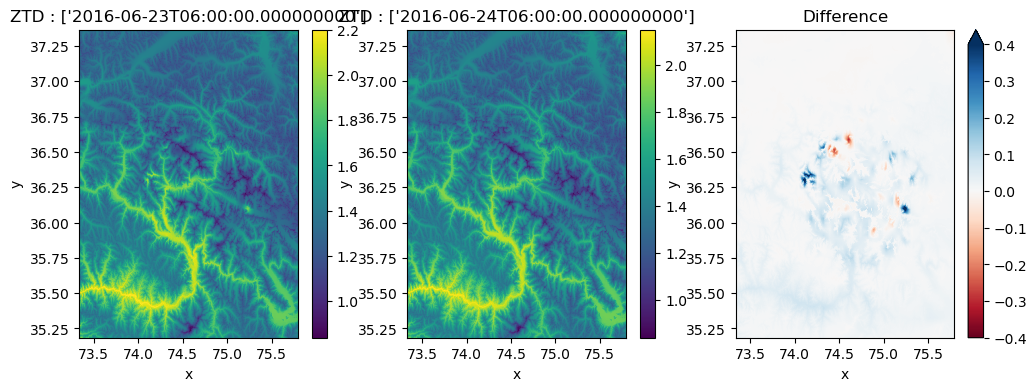

In [117]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd_clip.plot.imshow(ax=ax[0])
tropo_ztd2.plot.imshow(ax=ax[1])
(tropo_ztd_clip - tropo_ztd2).plot.imshow(ax=ax[2], vmin=-0.4, vmax=0.4, cmap='RdBu')
ax[0].set_title(f'ZTD : {ztd.time.values}')
ax[1].set_title(f'ZTD : {ztd2.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference quantile')

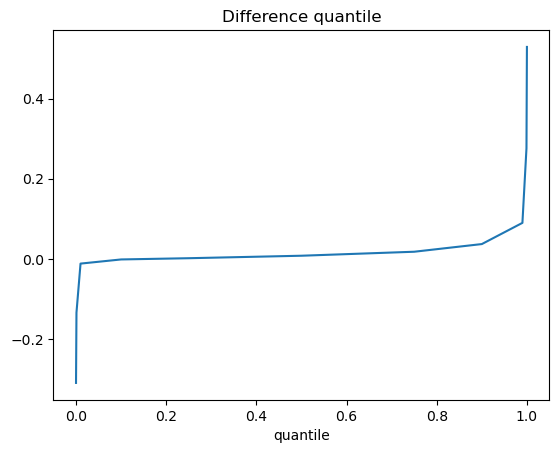

In [180]:
(tropo_ztd_clip - tropo_ztd2).quantile([0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 1]).plot()
plt.title('Difference quantile')

Text(0.5, 1.0, 'Difference')

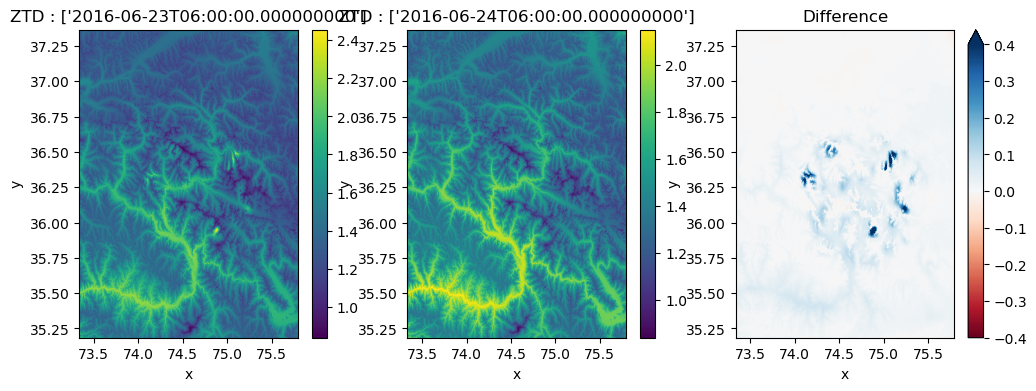

In [118]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
tropo_ztd_interp.plot.imshow(ax=ax[0])
tropo_ztd2.plot.imshow(ax=ax[1])
(tropo_ztd_interp - tropo_ztd2).plot.imshow(ax=ax[2], vmin=-0.4, vmax=0.4, cmap='RdBu')
ax[0].set_title(f'ZTD : {ztd.time.values}')
ax[1].set_title(f'ZTD : {ztd2.time.values}')
ax[2].set_title(f'Difference')

Text(0.5, 1.0, 'Difference_interp-before')

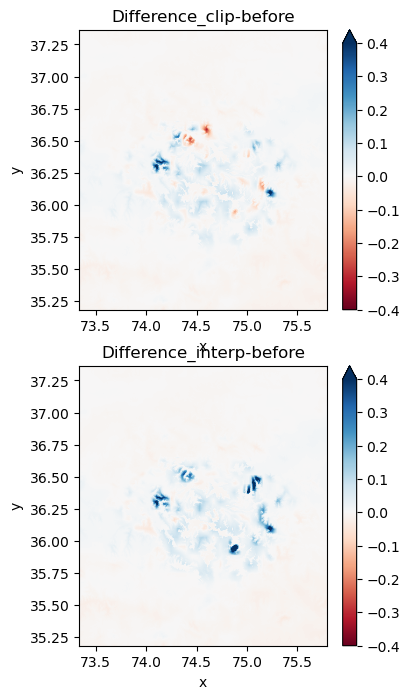

In [190]:
fig, ax = plt.subplots(2,1, figsize=(4,8))
(tropo_ztd_clip - tropo_ztd1).plot.imshow(ax=ax[0], vmin=-0.4, vmax=0.4, cmap='RdBu')
(tropo_ztd_interp - tropo_ztd1).plot.imshow(ax=ax[1], vmin=-0.4, vmax=0.4, cmap='RdBu')
ax[0].set_title(f'Difference_clip-before')
ax[1].set_title(f'Difference_interp-before')

Text(0.5, 1.0, 'Difference_interp-after')

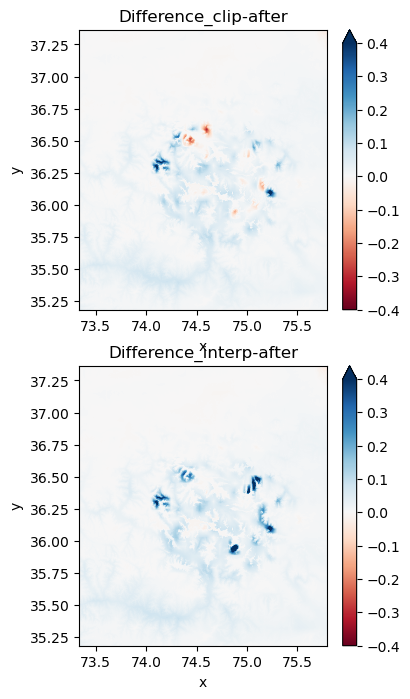

In [189]:
fig, ax = plt.subplots(2,1, figsize=(4,8))
(tropo_ztd_clip - tropo_ztd2).plot.imshow(ax=ax[0], vmin=-0.4, vmax=0.4, cmap='RdBu')
(tropo_ztd_interp - tropo_ztd2).plot.imshow(ax=ax[1], vmin=-0.4, vmax=0.4, cmap='RdBu')
ax[0].set_title(f'Difference_clip-after')
ax[1].set_title(f'Difference_interp-after')

Text(0.5, 1.0, 'Difference quantile')

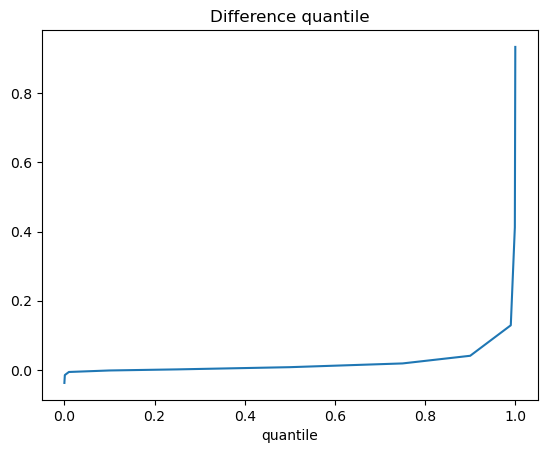

In [181]:
(tropo_ztd_interp - tropo_ztd2).quantile([0, 0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.999, 1]).plot()
plt.title('Difference quantile')